# Causal DAGs

Encoding causal assumptions in a causal graph via DAGs is mandatory for performing trustable causal inference, according to many scholars such as Judea Pearl ([Pearl, 2018](https://ftp.cs.ucla.edu/pub/stat_ser/r481.pdf)). There's quite a bit of lore behind this and has been a debate topic for many decades. I personally first read about this tale in Judea Pearl's "The Book of Why". Of-course, because I read it from Pearl's POV, my impression is that the debate has been more favorable for Pearl, although I acknowledge that I can't know for sure. Nevertheless, it is true that in almost every causal inference textbook I've seen, there is at least one section on DAGs, and in my personal experience at work, I've found it quite useful in communicating my assumptions.

There are a plethora of resources to learn how DAGs work, but some good ones are the sections on DAGs in Robin and Hernan's "Causal Inference: What If" free online textbook as well as ([VanderWeele, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6447501/)).

There's also quite a number of packages for drawing DAGs, and my personal favorite is the R package `ggdag`, but you can find a review of them in ([Pitts and Fowler, 2023](https://arxiv.org/pdf/2305.12006.pdf))

Below, we'll go over a few examples of DAGs along with the code to generate them.

## install and load packages

In [1]:
# enable usage of R
import rpy2.ipython
%load_ext rpy2.ipython

In [4]:
%%R
#install.packages('ggdag') # uncomment this one to install it first. Can take some time to install
library('ggdag')
library('ggplot2')

## Some DAG examples

The simplest causal DAG example you see in most articles is the triangle:

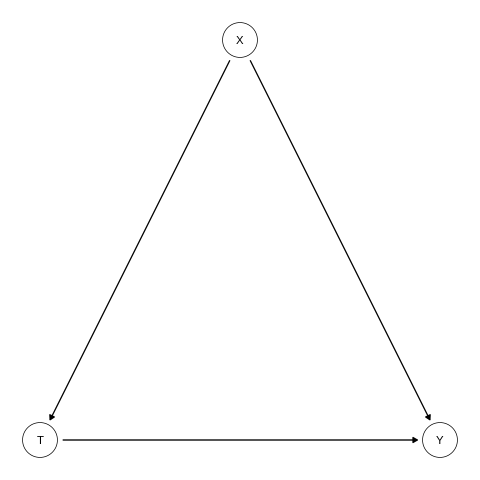

In [9]:
%%R
dag <- dagify(Y~T+X, T~X, coords=list(x=c(Y=2,T=0,X=1),y=c(Y=0,T=0,X=1)))
dag %>% ggplot(aes(x=x,y=y,xend=xend,yend=yend))+geom_dag_point(shape=1)+geom_dag_edges()+theme_void()+geom_dag_text(color='black',parse=TRUE)

The above DAG encodes that a vector of covariates $\mathbb{X}$ confound the causal effect of the treatment $T$ on $Y$.

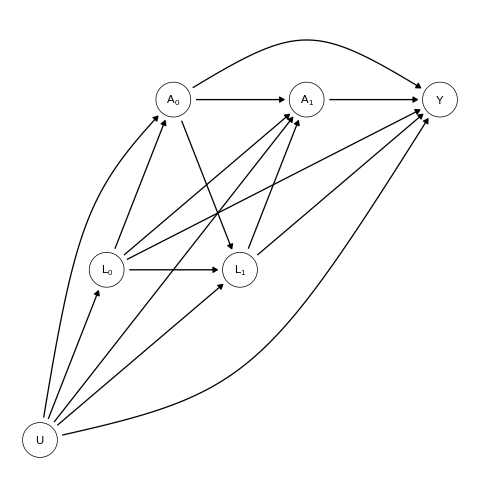

In [10]:
%%R
dag2 <- dagify(
    # relations
    L0 ~ U,
    A0 ~ L0 + U,
    L1 ~ A0 + L0 + U,
    A1 ~ A0 + L1 + L0 + U,
    Y ~ A1 + L1 + A0 + L0 + U,
    # Location of each node
  coords = list(
      x = c(Y=6,A1=4,L1=3,A0=2,L0=1,U=0),
      y = c(Y=2,A1=2,L1=1,A0=2,L0=1,U=0)
  )
)
dag2 %>% ggplot(
    aes(x=x, y=y, xend=xend, yend=yend)
) +
geom_dag_point(shape=1) +
geom_dag_edges_arc(
curvature = c(0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, -0.15)) +
theme_void() +
geom_dag_text(
    # subscripts
    color = 'black',
    parse = TRUE,
    label = c(expression(A[0]), expression(A[1]), expression(L[0]), expression(L[1]), "U",'Y')
)

The above is a longitudinal DAG that allows for treatments $A_t$ and covariates $L_t$ to affect each other in a sequential manner. One way that this DAG is tackled is using a Marginal Structural Model ([Robins, Hernan, and Brumback, 2000](https://www.hsph.harvard.edu/wp-content/uploads/sites/1268/2014/11/Marginal_Structural_Models_and_Causal_Inference_in.11.pdf)). Notice how there is the unobserved confounder $U$. MSMs cannot control for that automatically so in the presense of meaningful unobserved confounders, the treatment effect will be biased.

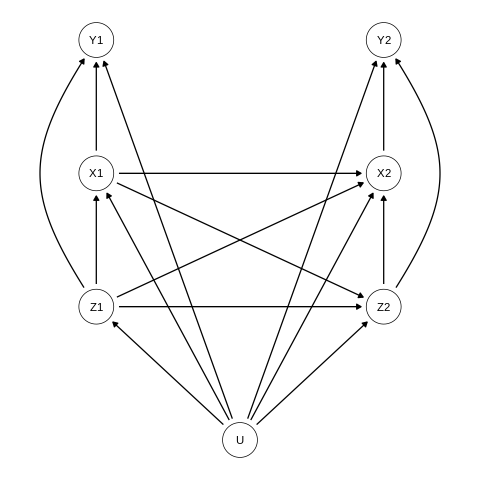

In [11]:
%%R
dag2 <- dagify(
    # relations
    Y1 ~ X1+Z1+U,
    Y2 ~ X2+Z2+U,
    X1 ~ Z1+U,
    Z1 ~ U,
    X2 ~ X1+Z1+Z2+U,
    Z2 ~ Z1+X1+U,
    # Location of each node
    coords = list(
      x = c(Y1=1,Y2=3,X1=1,X2=3,Z1=1,Z2=3,U=2),
      y = c(Y1=4,Y2=4,X1=3,X2=3,Z1=2,Z2=2,U=1)
  )
)
dag2 %>% ggplot(
    aes(x=x, y=y, xend=xend, yend=yend)
) +
geom_dag_point(shape=1) +
geom_dag_edges_arc(curvature = c(0,0,0,0,0,0,0,0,0,0,0,0,0.35,0,0,-0.35)) +
theme_void() +
geom_dag_text(
    # subscripts
    color = 'black',
    parse = TRUE
)

The above DAG is similar to the one before, but a difference is that the outcome is also sampled more than once. Data like this is called panel data and is extremely popular in Economics (although Pearl has noted that until recently, economics encoded their assumptions in a regression model as opposed to a graph). This is a DAG from ([Imai and Kim, 2019](https://imai.fas.harvard.edu/research/files/FEmatch.pdf)). In their paper, they explain how fixed effects has been a very popular method because unobserved time-invariant confounders $U$ is automatically controlled for in fixed effects. However, they also discuss the arsenal of nuances that analysts must keep in mind when using panel methods such as fixed effects. Just to give a taste of the nuance, if one wants to add dynamic causal relationships (i.e., allow for $Y_1$ to have an arrow to $Y_2$), then we cannot include time-varying covariates $Z_t$ in the model if the goal is to retain causal identifiability. Another example is that in fixed effects models, you have the option to control for time-invariant unobserved confounders or unit-invariant unobserved confounders. Asking for both is called two-way fixed effects, but according to the authors, this actually invalidates causal identification, despite its popularity.